<a href="https://colab.research.google.com/github/MohammedNasserAhmed/MHIP/blob/master/MHIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **[ 1 ]  Install the required Libraries**

In [95]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = [
                      "pip install sklearn",
                      "pip install scikit-learn",
                      "pip install plotly",
                      "pip install statsmodels",
                      "pip install panel",
                      "pip install colorama"
                    ]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

## **[ 2 ] Import GDrive**

In [96]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **[ 3 ] Import the required pthon packages**

In [97]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
import panel as pn
from colorama import Fore, Style, Back
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import pickle
from tabulate import tabulate
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn import tree
from sklearn import metrics
import joblib
from typing import List, Union

## **[ 4 ] Extra Settings**

In [98]:
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format
pal = ['#C060A1', '#46C2CB', '#ECB365','#FF0000','#0039A6','#414A4C']
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = 8
plt.rcParams['text.color'] = '#0039A6'

## **[ 5 ] Backup Functions**

In [99]:
# Define CSS styling
css = """
<style>
    table {
        width: 50%;
        text-align: center;
        'font-size': '12pt';

    }
    th, td {
        padding: 8px;
        text-align:center;
    }
    th {
        background-color: #C70039;
        color: white;

    }
    td {
        text-align:center!important;
        background-color: #EEEEEE;
        color: black;
    }
    td::after {
			content: attr(data-value ":.2f");
            }
</style>
"""
def printout(data, show_index=False, cells_colors=False):
    """
    Function to display a pandas DataFrame with custom formatting.
    Removes trailing zeros and formats float numbers to 2 decimal places.
    """
    data = data.applymap(lambda x: "{:.2f}".format(x).rstrip('0').rstrip('.') if isinstance(x, float) else x)
    styled_df = HTML(css + data.to_html(index=show_index))
    display(styled_df)

def encode_categoricals(data):
    """
    Function to encode categorical columns in a pandas DataFrame using factorize method.
    """
    categorical_columns = data.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        data[column], _ = pd.factorize(data[column])
    return data


## **[ 6 ] Dataset**

#### **Introduction**

The dataset used in this section is the insurance.csv dataset, which contains 1338 observations and 7 features. The features are:

* Independet Features :
 1. Age: Age of the customer.
 2. BMI: Body Mass Index of the individual.
 3. Children: Number of children individual has.
 4. Smoker: Is that individual a smoker or not.
 5. Region: Which region/part individual lives in.

* Dependent Feature
 6. Charges: The charges column is our target/independent feature.

The dataset contains 4 numerical features (age, BMI, children, and charges) and 3 categorical features (smoker, region, and charges). The goal is to use this dataset to predict the insurance charges of individuals.


#### **TO-DO List**

* Load the dataset
* Get the dimensionality (no. of features (columns) and observations(rows))
* DTypes and names of features
* Descriptive statistics (Max, min, mean, median and std for each continuous feature)
* Declare the target variable (feature)


#### **[ 6 : 1 ] Load the Dataset**

In [100]:
# Function to print colored output
def print_output(message, data):
    print(message)
    printout(data)

# Load the dataset
df = pd.read_csv('/content/gdrive/MyDrive/Colab_Notebooks/Medical Health Insurance Cost Prediction /us_insurance.csv')

# Print top 5 observations
print_output("The Top 5 observations of Dataset: \n", df.head())

# Print tail 5 observations
print_output("\n\n The Tail 5 observations of Dataset: \n", df.tail())

The Top 5 observations of Dataset: 



age,sex,bmi,children,smoker,region,charges
19,female,27.9,0,yes,southwest,16884.92
18,male,33.77,1,no,southeast,1725.55
28,male,33,3,no,southeast,4449.46
33,male,22.7,0,no,northwest,21984.47
32,male,28.88,0,no,northwest,3866.86




 The Tail 5 observations of Dataset: 



age,sex,bmi,children,smoker,region,charges
50,male,30.97,3,no,northwest,10600.55
18,female,31.92,0,no,northeast,2205.98
18,female,36.85,0,no,southeast,1629.83
21,female,25.8,0,no,southwest,2007.94
61,female,29.07,0,yes,northwest,29141.36


#### **[ 6 : 2 ] Get the dimensionality**

In [101]:
print(Fore.BLUE + Style.BRIGHT +
      f"The no. of observations :"+
      Fore.LIGHTRED_EX +
      f"{len(df)} \n\n" +
      Fore.BLUE +
      "The no. of features :"+
      Fore.LIGHTRED_EX +
      f"{len(df.columns)}\n\n" +
      Fore.BLUE +
      "The Dataset shape is : " +
      Fore.LIGHTRED_EX +
      f"{df.shape}"
      + Style.RESET_ALL)


The no. of observations :1338 

The no. of features :7

The Dataset shape is : (1338, 7)


#### **[ 6 : 3 ] DTypes and names of features**

In [102]:
def print_dtype(df):
    """Prints the name and dtype of each column in the DataFrame"""
    for col in df.columns:
        print(f"{Fore.BLUE}{Style.BRIGHT}The feature name and dtype | {Fore.GREEN}{col} --> {df[col].dtype}{Style.RESET_ALL}")

def get_features(df):
    """Returns a list of feature names, removing any single quotes"""
    return [name.replace("'", "") for name in df.columns]

def get_cat_features(df):
    """Returns a list of categorical feature names"""
    return df.select_dtypes(include=['object', 'category']).columns.to_list()

def get_num_features(df, cat_features):
    """Returns a list of numerical feature names"""
    return df.drop(columns=cat_features).columns.tolist()

def print_features(df):
    """Prints the feature names, categorical feature names, and numerical feature names"""
    features = get_features(df)
    cat_features = get_cat_features(df)
    num_features = get_num_features(df, cat_features)

    print(f"{Style.BRIGHT}\n\nThe dataset features : {Fore.MAGENTA}{', '.join(features)} \n{Fore.BLACK}The categorical features : {Fore.MAGENTA}{', '.join(cat_features)}{Fore.BLACK}\nThe continuous features : {Fore.MAGENTA}{', '.join(num_features)}{Style.RESET_ALL}")

# Call the functions
print_dtype(df)
print_features(df)

The feature name and dtype | age --> int64
The feature name and dtype | sex --> object
The feature name and dtype | bmi --> float64
The feature name and dtype | children --> int64
The feature name and dtype | smoker --> object
The feature name and dtype | region --> object
The feature name and dtype | charges --> float64


The dataset features : age, sex, bmi, children, smoker, region, charges 
The categorical features : sex, smoker, region
The continuous features : age, bmi, children, charges


#### **[ 6 : 4 ] Descriptive Statistics**

In [103]:
print("The Continuous Variables (features) \n")
printout(df.describe(), show_index=True)
print("\nThe Categorical Variables (features) \n")
printout(df.describe(include="object"), show_index=True)

The Continuous Variables (features) 



,age,bmi,children,charges
count,1338,1338,1338,1338
mean,39.21,30.66,1.09,13270.42
std,14.05,6.1,1.21,12110.01
min,18,15.96,0,1121.87
25%,27,26.3,0,4740.29
50%,39,30.4,1,9382.03
75%,51,34.69,2,16639.91
max,64,53.13,5,63770.43



The Categorical Variables (features) 



,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Zoom in on the highest and lowest charges in the dataset ⏬

In [104]:
def print_max_min_charges(df):
    # Get the max and min charges in the dataset
    max_charge = df.loc[df['charges'].idxmax()]
    min_charge = df.loc[df['charges'].idxmin()]

    # Combine both observations into a dataframe
    max_min_charges = pd.DataFrame({'The Highest Charges': max_charge, 'The Lowest Charges': min_charge})

    # Print the dataframe with index
    printout(max_min_charges, show_index=True)

print_max_min_charges(df)

,The Highest Charges,The Lowest Charges
age,54,18
sex,female,male
bmi,47.41,23.21
children,0,0
smoker,yes,no
region,southeast,southeast
charges,63770.43,1121.87


**Insights :**





You can see the notable differences in charges as well as in other features like age, BMI, and Smoker by looking at the highest and lowest table. It's still early to determine or recognize the importance of predictors. However, further analysis and research are needed to fully understand their impact on insurance charges.



The person with the highest rate of charges is a smoker, 54 years old, and has a 47 BMI ( that means he's obese; according to the World Health Organization (WHO), a BMI of less than 18.5 is considered underweight, a BMI between 18.5 and 24.9 is considered normal weight, a BMI between 25 and 29.9 is considered overweight, and a BMI of 30 or higher is considered obese), while the individual with lower insurance charges looks younger, smokes less, and has a healthier lifestyle overall.

#### **[ 6 : 5 ] Declare the target variable (feature)**

***Target Variable*** : is the variable that the model is trying to predict or estimate. It is also known as the dependent variable or response variable. In regression models like this, the target variable is typically a continuous variable, such as a numeric value or a real number, and the goal is to find a relationship between the target variable and one or more predictor variables, also known as independent variables or features.

***The purpose of model*** is to predict the insurance ***chrages*** (target variable) by using some predictor variables *( age, sex, bmi, children, smoker, region )*

In [105]:
def format_charges(value):
    return '{:.2f}$'.format(value)

def print_charge_stats(label, value, color):
    print(f"{Style.BRIGHT}\n{label} : {color}{value}{Style.RESET_ALL}")

charges_stats = df['charges'].agg(['max', 'min', 'mean']).apply(format_charges)

print_charge_stats("The maximum Charges", charges_stats[0], Fore.GREEN)
print_charge_stats("The minimum Charges", charges_stats[1], Fore.MAGENTA)
print_charge_stats("The average of Charges", charges_stats[2], Fore.RED)


The maximum Charges : 63770.43$

The minimum Charges : 1121.87$

The average of Charges : 13270.42$


## **[ 7 ] Expolatory Data Analysis (EDA)**


EDA is an essential step in regression modeling that involves understanding the distribution of variables and identifying relationships. Various visualization libraries like seaborn, matplotlib, and plotly are used to create different plots and graphs to gain insights into the datase . Some significant questions to ask and answer during the EDA process for a health insurance prediction project with the given dataset include:

1. What is the distribution of the target variable (charges)?

2. What is the distribution of each attribute in the dataset, including age, sex, BMI, children, region, and smoker status?

3. Are there any missing or null values in the dataset? If so, how are they distributed across the attributes?

4. What is the correlation between each attribute and the target variable (charges)? Which attributes have the strongest correlation with the target variable?

5. Are there any significant differences in the distribution and correlation of the attributes based on different categories or subgroups (e.g., age, sex, smoker status, region)?

6. Are there any outliers in the dataset? If so, how do they affect the distribution and correlation of the attributes?

7. What insights can be gained from visualizing the data using scatter plots, histograms, box plots, and other visualization techniques?

8. Are there any significant interactions between the attributes that affect the prediction of the target variable?

Answering these questions can help to identify patterns, trends, and relationships in the data, and can provide valuable insights for feature engineering and model selection.

#### **[7 : 1] Distribuation of Target Variable (chargs)**

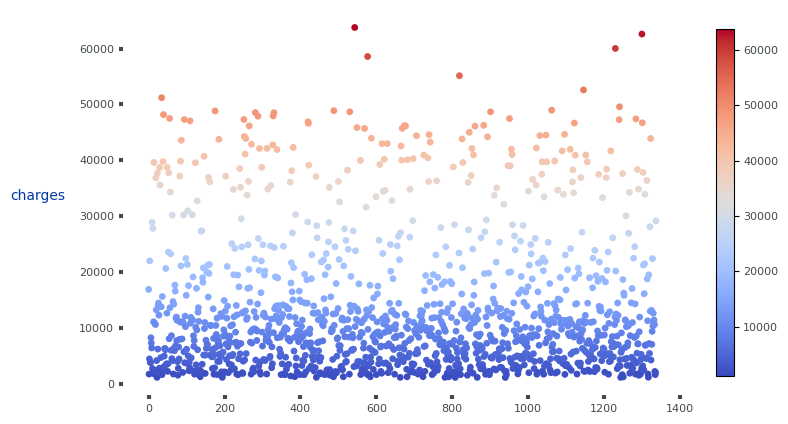

In [106]:
plt.figure(figsize=(9, 5))
plt.scatter(df.index, df['charges'], c = df['charges'], cmap='coolwarm', s=15)
cbar = plt.colorbar(pad=0.05,shrink=0.9)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(8)
     t.set_color("#414A4C")
ax= plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_ylabel('charges', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

plt.show()

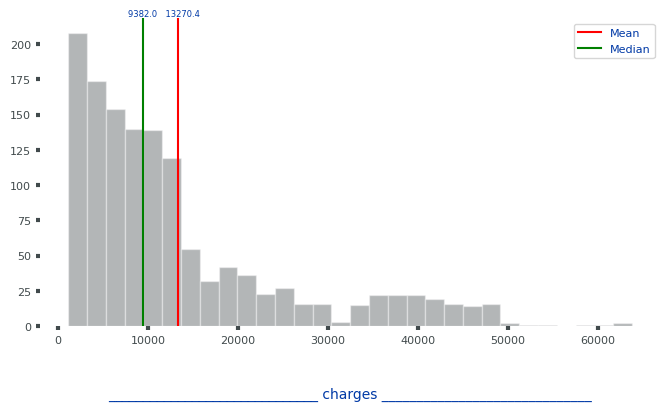

In [107]:
plt.figure(figsize=(8, 4))
sns.distplot(df['charges'], kde=False,color='#414A4C', hist_kws={'edgecolor': 'white'})
plt.axvline(x=np.mean(df['charges']), color = 'red', label='Mean',)
plt.text(np.mean(df['charges']), plt.ylim()[1], f"    {np.mean(df['charges']):.1f}", ha='center', va='bottom', size=6)
plt.text(np.mean(df['charges']), plt.ylim()[1], f"{np.median(df['charges']):.1f}        ", ha='right', va='bottom', size=6)

plt.axvline(x=np.median(df['charges']), color = 'green', label='Median')
plt.legend(loc="upper right")
ax= plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0)
ax.set_xlabel('______________________________ charges ______________________________', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

plt.show()

#### **[ 7 : 2 ] Target Variable Vs. Independent Variables**

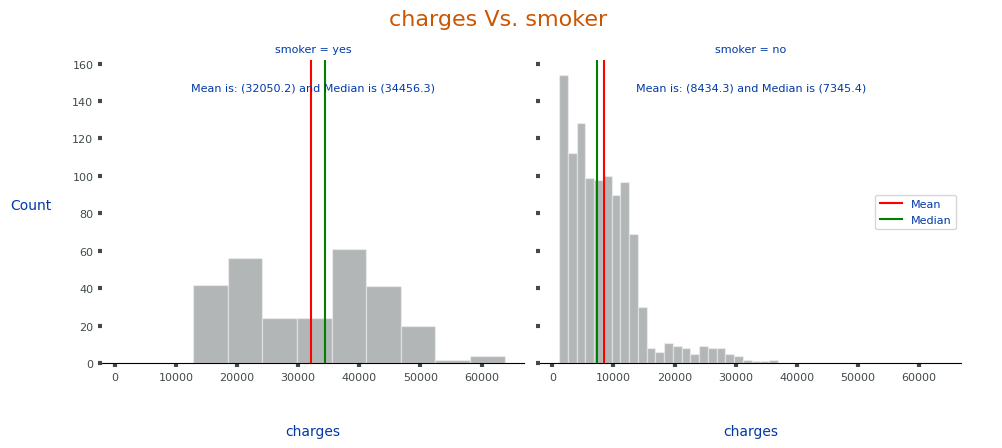

In [108]:
#plt.rcParams['text.color'] = '#CC5500'
def create_plot(data, var_1="smoker", var_2 = "charges", metrics=True, metrics_size= 8):

    g = sns.FacetGrid(data, col=var_1)

    g.add_legend()
    g.legend.get_title().set_fontsize(30)
    g.fig.set_size_inches(10, 4.5)

    g.fig.suptitle(f'{var_2} Vs. {var_1}', fontsize=16, color ="#CC5500")

    for ax in g.axes.flat:
        ax.set_xlabel(var_2, fontsize=10, color='#0039A6', labelpad=30)
        ax.set_ylabel('Count', fontsize=10, color='#0039A6', rotation = 360, labelpad=30)
        ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)
        ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)
    g.map(sns.distplot, var_2, color='#414A4C', kde=False,hist_kws={'edgecolor': 'white'})

    if metrics == True:
        for category, ax in g.axes_dict.items():
            # Get the count of each level
            mean = df[df[var_1] == category][var_2].mean()
            median = df[df[var_1] == category][var_2].median()
            ax.axvline(x=mean, color = 'red', label='Mean')
            ax.axvline(x=median, color = 'green', label='Median')

            ax.text(0.5, 0.9, f"Mean is: ({mean :.1f}) and Median is ({median :.1f})",
                transform=ax.transAxes, ha='center', color="#0039A6", size = metrics_size)
        plt.legend(loc="center right")
    for ax in g.axes.flat:
        ax.spines['left'].set_visible(False)

    return  plt.show()
create_plot(df)

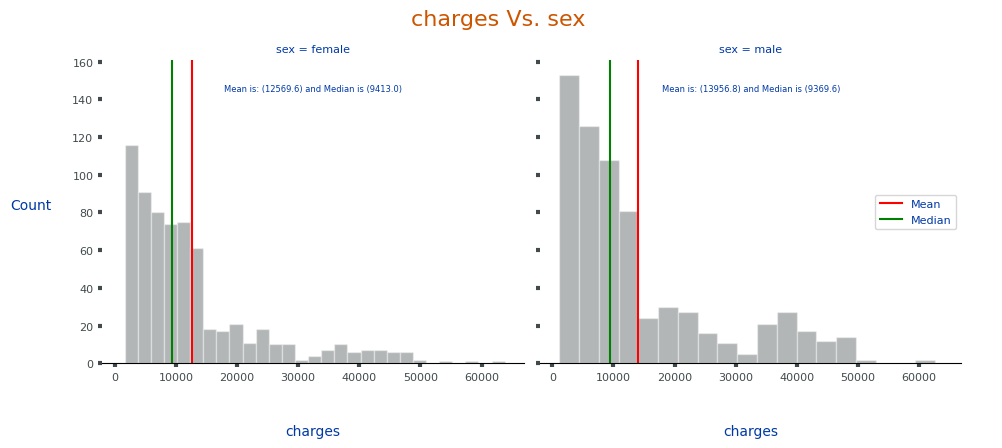

In [109]:
create_plot(data=df,var_1='sex', metrics = True, metrics_size = 6)

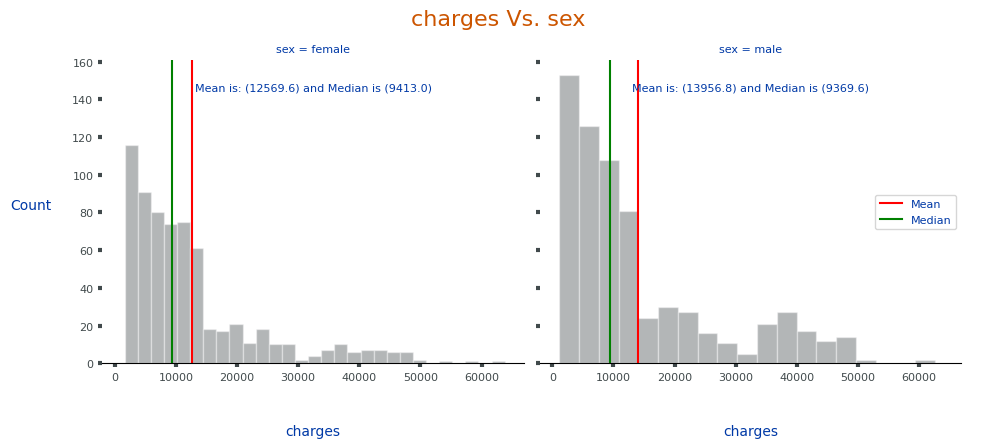

In [110]:
create_plot(data=df,var_1='sex', metrics = True)

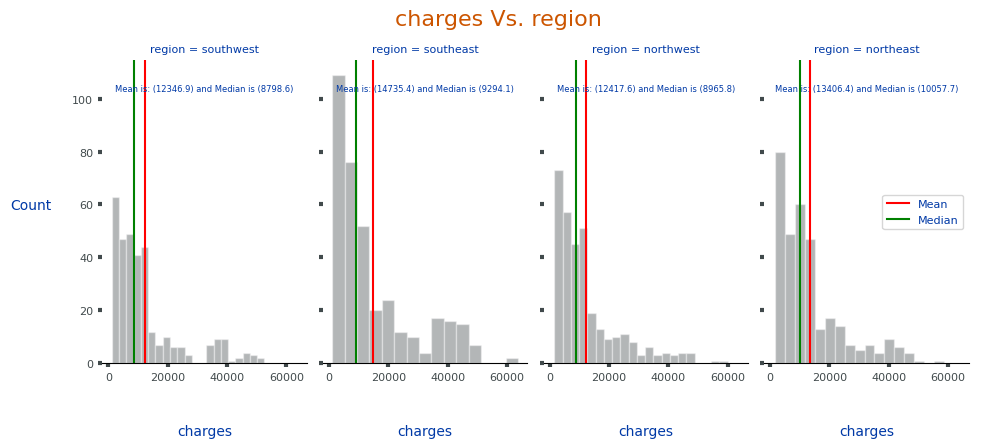

In [111]:
create_plot(data=df,var_1='region', metrics = True, metrics_size=6)

In [112]:
def bivariate_plot(data, hue, var):
    # Initialize the FacetGrid object
    g = sns.FacetGrid(data, hue=hue, palette=pal,
                      hue_kws={'marker': ['o', 's', 'D', 'v', '^', '*']}, height=5)

    # Set figure size
    g.fig.set_size_inches(8, 5)

    # Set title of the figure
    g.fig.suptitle(f'Charges Vs. {var} Vs. {hue}', fontsize=12, color="#C70039")

    for ax in g.axes.flat:
        # Set visibility of left and bottom spines
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # Set the labels for the y-axis and x-axis
        ax.set_ylabel(var, fontsize=10, rotation=360, labelpad=30, color="#0039A6")
        ax.set_xlabel('charges', fontsize=10, rotation=360, labelpad=30, color="#0039A6")

        # Set the color of the x-axis and y-axis tick marks and labels
        ax.tick_params(axis='x', colors='#414A4C', length=3, width=3, labelsize=8)
        ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

    # Add a scatterplot to the grid
    g.map(sns.scatterplot, "charges", var, s=50, alpha=.7)

    # Add a legend to the grid
    g.add_legend()

    # Show the plot
    plt.show()

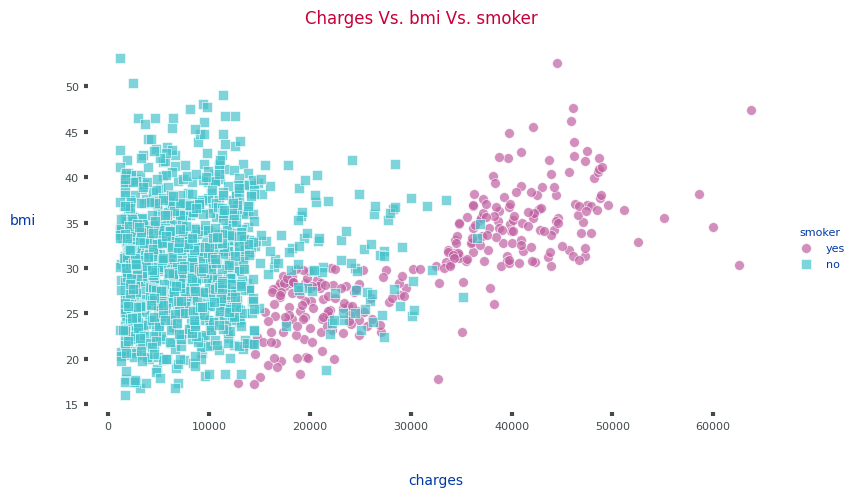

In [113]:
bivariate_plot(df, hue='smoker', var = "bmi")

In [114]:
def barplot(data, var, hue):
    plt.rcParams['font.size'] = 8
    g = sns.barplot(data=data, x=var, y='charges', hue=hue, palette=pal, width=0.6)
    g.set_title(f' charges Vs. {var}  (Hue : {hue})', fontsize=12, color="#C70039",  y=1.1)
    fig, ax = plt.gcf(), plt.gca()

    setup_figure_and_axes(fig, ax)
    setup_labels_and_ticks(ax, var)
    annotate_bars(ax, data, var, hue)
    setup_legend(ax)

    plt.show()


def setup_figure_and_axes(fig, ax):
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.1, 0.9))
    fig.set_figwidth(8)
    fig.set_figheight(4)
    for spine in ax.spines.values():
        spine.set_linewidth(0)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


def setup_labels_and_ticks(ax, var):
    ax.set_ylabel("charges", fontsize=10, rotation=360, labelpad=30, color="#0039A6")
    ax.set_xlabel(var, fontsize=10, rotation=360, labelpad=30, color="#0039A6")
    ax.tick_params(axis='x', colors='#414A4C', length=3, width=3, labelsize=8)
    ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)


def annotate_bars(ax, data, var, hue):
    v = h = 0
    for i, p in enumerate(ax.patches):
        unique_var_values = data[var].unique().tolist()
        hue_value_counts = data[data[var] == unique_var_values[v]][hue].value_counts()
        cat, total = hue_value_counts[h], len(data[data[var] == unique_var_values[v]])
        precentage = "{:.2f} %".format((100 * cat) / total)
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.1 * height, precentage, ha="center", fontsize=6, color='#0039A6')
        v += 1
        if v >= data[var].nunique():
            v, h = 0, h + 1


def setup_legend(ax):
    plt.setp(ax.get_legend().get_texts(), fontsize='6', fontweight='bold', color="#0039A6")
    plt.setp(ax.get_legend().get_title(), fontsize='8', color="#C70039")

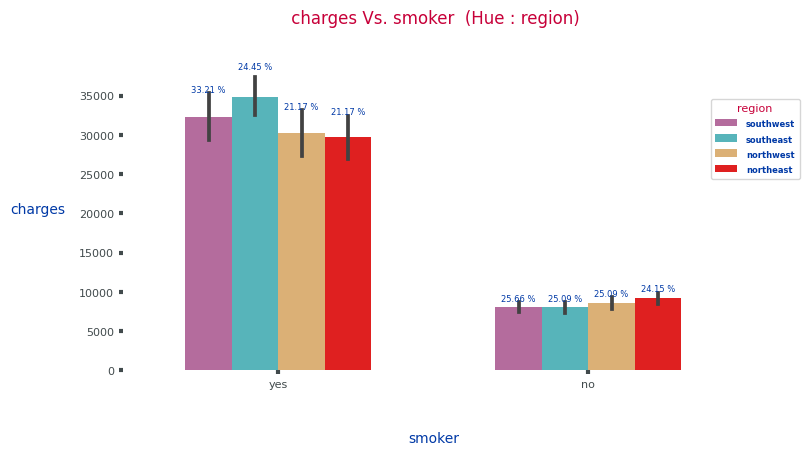

In [115]:
barplot(df, "smoker","region")

In [116]:
def plot_regression(df):
    plot_config = {
        'font.size': 11,
        'text.color': "#414A4C"
    }

    plt.rcParams.update(plot_config)

    g = sns.lmplot(x="bmi", y="charges", row="sex", col="region", hue='smoker', data=df, palette="Set1")

    modify_axes(g)

    plt.show()


def modify_axes(g):
    g.fig.suptitle('Regression Plot of Charges Vs. BMI considering (Hue : Smoker)', fontsize=20, color ="#C70039",  y=1.1)

    for ax in g.axes.flat:
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        ax.set_ylabel("charges", fontsize=14, rotation=360, labelpad=40, color="#0039A6")
        ax.set_xlabel('BMI', fontsize=14, rotation=360, labelpad=30, color="#0039A6")

        ax.tick_params(axis='x', colors='#414A4C', length=3, width=3, labelsize=12)
        ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=12)

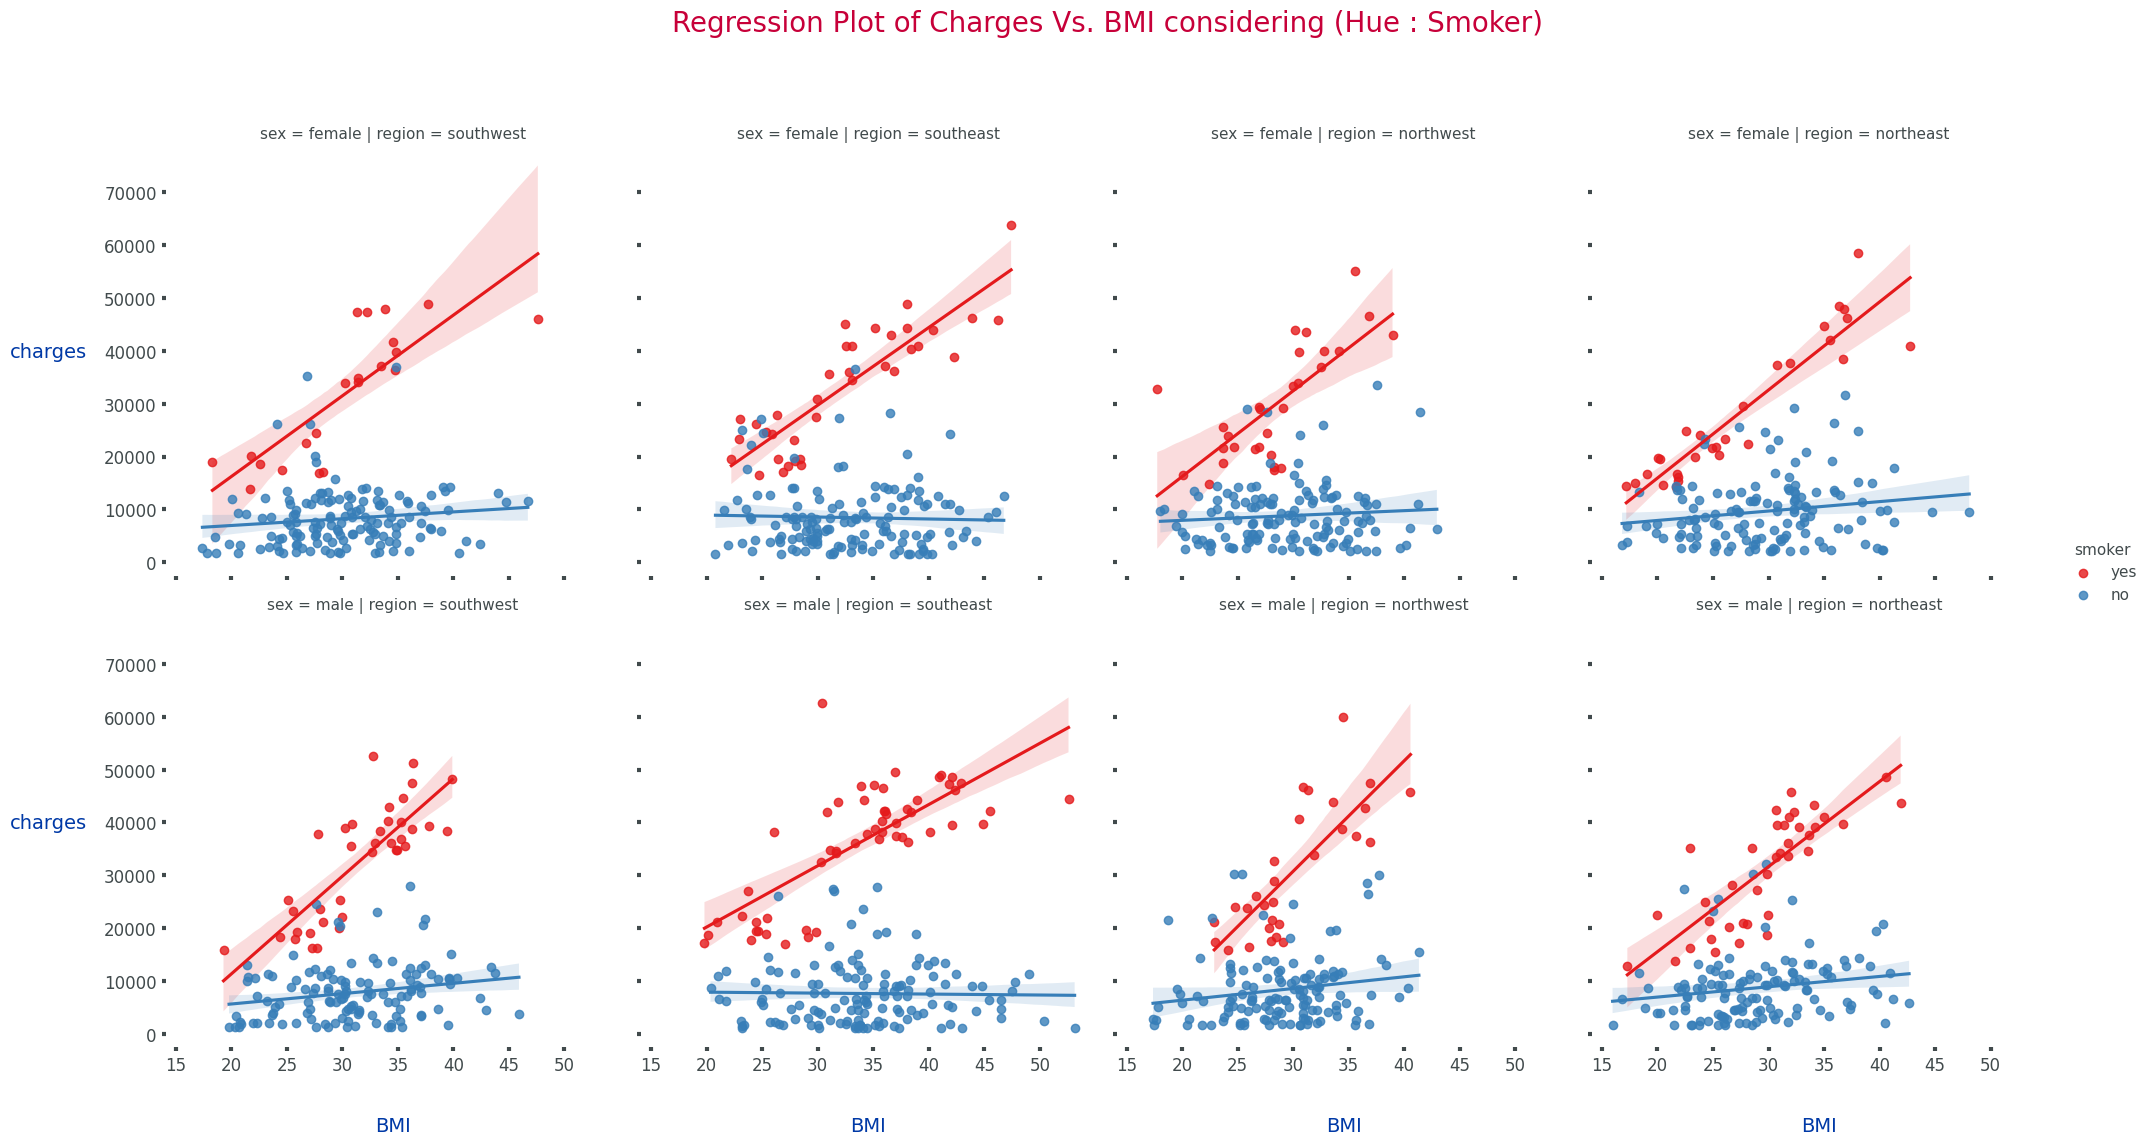

In [117]:
plot_regression(df)

#### **PANEL Board**

In [118]:
#pn.extension(sizing_mode="stretch_width", design='material', template="fast")
#variable_widget_1 = pn.widgets.Select(name="categorical variables", value="smoker", options=df.select_dtypes(include=['object', 'category']).columns.to_list())
#variable_widget_2 = pn.widgets.Select(name="continous variables", value="charges", options=df.select_dtypes(exclude=['object', 'category']).columns.to_list())
#bound_plot = pn.bind(create_plot,data=df, var_1=variable_widget_1, var_2=variable_widget_2)


In [119]:
#app = pn.Column(variable_widget_1, variable_widget_2, bound_plot)
#app

#### **[ 7 : 3 ] Data Preparation and Cleansing**

**8-Step checklist**

* Missing Values :
* Dublicate and Low Variation Data
* Incorrect and Irrelevant Data
* Categorical Data
* Outliers
* Feature Scaling
* Feature Selection
* Validation Split

**Missing Values**

In [120]:
def print_missing_values_info(df):
    """
    Function to print information about missing values in our dataset.

    Parameters:
    df (DataFrame): The dataset to check for missing values.

    """
    # Check missing values in total dataset
    missing_any = df.isnull().values.any()
    print(f"{Style.BRIGHT}Any NULL values: {Fore.BLUE}{missing_any}{Style.RESET_ALL}\n")

    # Check missing values per column
    missing_per_feature = df.isnull().sum().astype(int).to_string(index=True, header=False)
    print(f"{Style.BRIGHT}NULL values per feature:\n {Fore.GREEN}{missing_per_feature}\n{Style.RESET_ALL}")

print_missing_values_info(df)

Any NULL values: False

NULL values per feature:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0



***Insights*** : No missing values in the dataset

**Dublicated Data**

In [121]:
# Detect duplicated data
dups = df.duplicated()

# If there are any duplicates, print them out and then remove them
if dups.any():
    printout(df[dups], show_index=True)
    # Drop the duplicated observations by index
    df = df.drop(df[dups].index, axis=0).reset_index(drop=True)

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.56


***Insights*** : It can be seen that there is no duplicated data in the dataset except for a single observation. and in our case, the similarity may happen during the data collection process. There are no identical features here, just age, region, smoking habit, sex, and children. However, it is important to note that even though there are no identical features, the presence of observations with duplicated data can still affect the accuracy and reliability of the analysis. Since we're dealing with only one observation, we are fine to proceed with our analysis without any concerns.

**Incorrect and Irrelevant Data**

*Anomaly Detection Algorithms* :

 Isolation Forest model represents the anomaly score assigned to each data point in your dataset. Anomaly scores indicate how likely a data point is to be an outlier or anomaly. In the Isolation Forest algorithm, lower anomaly scores indicate a higher likelihood of being an anomaly. Anomaly scores usually range between -1 and 1, where values closer to -1 are considered more anomalous.

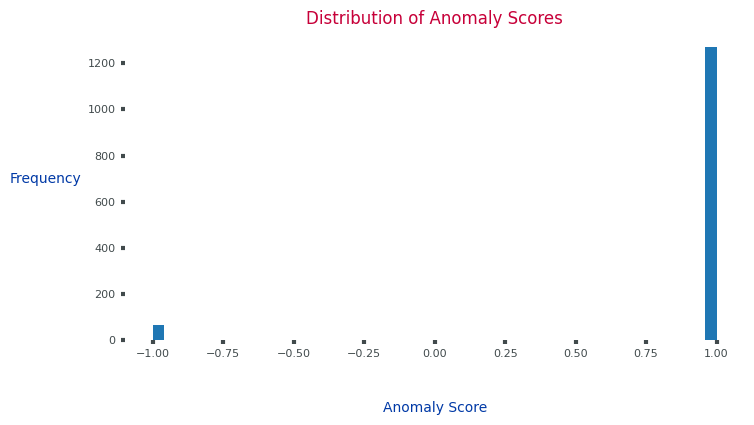

In [122]:
def preprocess_data(data):
    """Preprocesses the data."""
    data = data.drop('region', axis=1).copy()

    # get dummies of categorical features
    data = encode_categoricals(data)

    return data

def detect_anomalies(data):
    """Detects anomalies in the data."""
    iso_forest = IsolationForest(contamination=0.05)
    anomaly_scores = iso_forest.fit_predict(data)

    # Convert anomaly_scores to a Series
    anomaly_scores_series = pd.Series(anomaly_scores, index=data.index)

    # Filter out anomalies (rows with negative anomaly scores)
    filtered_df = data[anomaly_scores_series >= 0]
    filtered_df = filtered_df.reset_index(drop=True)

    return filtered_df, anomaly_scores

def plot_anomaly_scores(anomaly_scores):
    """Plots the distribution of anomaly scores."""
    plt.hist(anomaly_scores, bins=50)
    ax=plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0)
    ax.set_ylabel('Frequency', fontsize=10, rotation=360, labelpad=30, color = "#0039A6")
    ax.set_xlabel('Anomaly Score', fontsize=10, rotation=0, labelpad=30, color = "#0039A6")
    ax.tick_params(axis='x', colors='#414A4C',length=3, width=3, labelsize=8)  # Set the color of the x-axis tick marks and labels
    ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

    plt.title('Distribution of Anomaly Scores', fontsize=12, color ="#C70039")
    plt.show()


preprocessed_data = preprocess_data(df)
filtered_df, anomaly_scores = detect_anomalies(preprocessed_data)
plot_anomaly_scores(anomaly_scores)

***insights*** :  The dataset appears to contain some anomalies that need additional investigation or may even need to be removed, according to the anomaly detection algorithm discussed above. These anomalies could potentially affect the accuracy and reliability of any analysis or predictions made using the dataset. It is crucial to identify the cause of these anomalies and determine whether they are due to errors in data collection, measurement, or other factors before taking any further action. but we have no way to identify the cause, so the anomalous data points will be dropped from the dataset.

**Categorical Data**

In [123]:
# Get percentages of Categorical variables
for col in get_cat_features(df):
    printout(pd.DataFrame((df[col].value_counts(normalize=True) * 100).apply(lambda x: "{:.2f}".format(x).rstrip('0').rstrip('.') + " %")), show_index=True)

,sex
male,50.49 %
female,49.51 %


,smoker
no,79.51 %
yes,20.49 %


,region
southeast,27.23 %
southwest,24.31 %
northwest,24.23 %
northeast,24.23 %


In [124]:
# Count observations per level for all categoricl features
nums = df.select_dtypes(exclude=['object', 'category']).columns.to_list()
for col in get_num_features(df, nums):
    printout(pd.DataFrame(pd.crosstab(index=df[col],columns = "freq").rename_axis(None, axis=1)), show_index=True)

,freq
sex,
female,662
male,675


,freq
smoker,
no,1063
yes,274


,freq
region,
northeast,324
northwest,324
southeast,364
southwest,325


***Insights*** : You can see that there are three categorical features in the dataset, which include sex (male or female), smoker (yes or no), and region (southeast, southwest, northeast, northwest). The male category in sex feature is top with 50.52% (676 males), the positive-smokers category is top with 79.52% (1067 positive-smokers), which looks imbalanced and may require more attention during analsis, and the southeast region is top with 27.2% (regions have roughly equal distributions as follows: southeast (27.20%), southwest (24.29%), northwest (24.29%), and northeast (24.20%)). These categorical features provide valuable insights into the demographics and lifestyle choices of the individuals in the dataset, allowing for further analysis and understanding of potential factors influencing insurance charges.

**Feature Selection**

*USING ✴ Correlation with Random Forest Regressor*




 Correlation scores with train.corrwith(target) method : 



Feature,Importance
age,0.3
bmi,0.2
children,0.07
sex,0.06
region,0.01
smoker,-0.79



 Correlation scores with Random Forest Regressor method :



Feature,Importance
smoker,0.62
bmi,0.21
age,0.13
children,0.02
region,0.01
sex,0.01


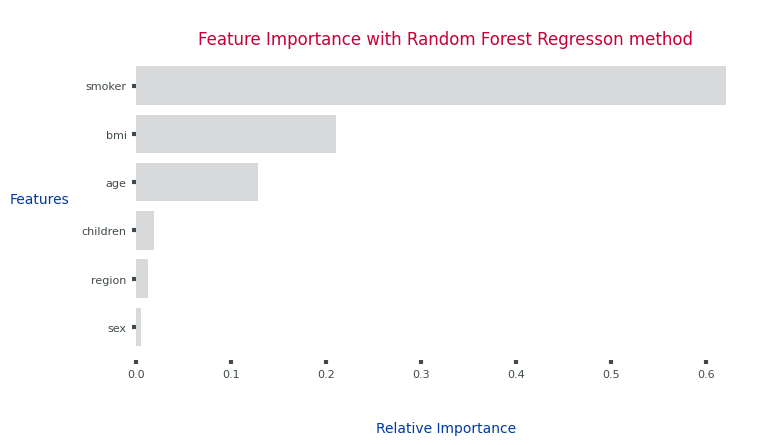

In [125]:
class DataAnalysis:
    def __init__(self, df, target):
        self.df = df
        self.X = df.drop(target, axis=1)
        self.y = df[target]

    def calculate_correlation(self):
        correlation = self.X.corrwith(self.y)
        return correlation

    def train_model(self, model):
        model.fit(self.X, self.y)
        return model

    def get_feature_importances(self, model):
        feature_importances = model.feature_importances_
        return feature_importances

    def plot(self, importance):
        indices = np.argsort(importance)
        plt.title('\nFeature Importance with Random Forest Regresson method', fontsize=12, color ="#C70039")
        plt.barh(range(len(indices)), importance[indices], color='#D8D9DA',   #4D3C77", "#C70039
        align='center')
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_linewidth(0)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_ylabel("Features", fontsize=10, rotation=360, labelpad=30, color="#0039A6")
        ax.set_xlabel("Relative Importance", fontsize=10, rotation=360, labelpad=30, color="#0039A6")
        ax.tick_params(axis='x', colors='#414A4C', length=3, width=3, labelsize=8)
        ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

        plt.yticks(range(len(indices)), self.X.columns[indices])
        plt.show()


    def display(self, importance, comment, return_importance=False):
        feature_importance = pd.DataFrame({'Feature': self.X.columns, 'Importance': importance})

        # Sort the DataFrame by importance score
        feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

        # Print the feature names and importance scores in a pretty format
        print(f"\n{comment}\n")
        printout(feature_importance)
        if return_importance :
            return feature_importance




ds = df.copy()
ds = encode_categoricals(ds)
analysis = DataAnalysis(ds, 'charges')

correlation = analysis.calculate_correlation()
analysis.display(correlation," Correlation scores with train.corrwith(target) method : ")

model = RandomForestRegressor(random_state=42)
trained_model = analysis.train_model(model)

feature_importances = analysis.get_feature_importances(trained_model)
feature_importance_df = analysis.display(feature_importances," Correlation scores with Random Forest Regressor method :", return_importance = True)
analysis.plot(feature_importances)

*USING ✴ Correlation with heatmap*

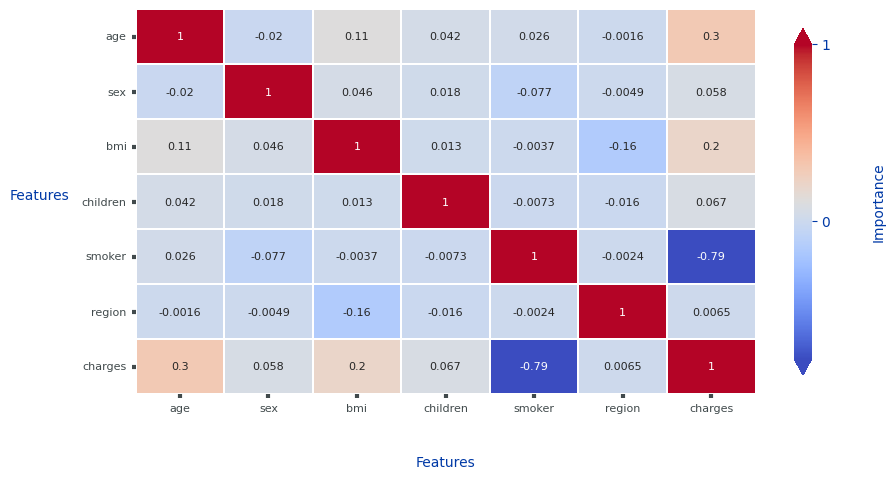

In [126]:
def plot_heatmap(data, figsize=(10, 5), cmap='coolwarm', linewidths=0.3, linecolor='white',annotfontsize=8, fontsize=10, labelpad=30, axis_color="#0039A6", tick_params={'colors':'#414A4C', 'length':3, 'width':3, 'labelsize':8}):
    """
    Function to plot a heatmap with specific formatting.

    Args:
    data (DataFrame): input data.
    figsize (tuple): size of the figure.
    cmap (str): colormap for the heatmap.
    linewidths (float): width of the lines that will divide each cell.
    linecolor (str): color of the lines that will divide each cell.
    fontsize (int): fontsize for the labels on the heatmap.
    labelpad (int): pad for the label.
    axis_color (str): color for the axis.
    tick_params (dict): parameters for the ticks.
    """

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(data.corr(), cmap=cmap, annot=True,
                cbar_kws={'shrink': 0.9, 'ticks': [-1, 0, 1],  'extend': 'both'},
                annot_kws={'fontsize': annotfontsize},
                linewidths=linewidths, linecolor=linecolor, ax=ax)

    # Removing the spines
    for spine in ax.spines.values():
        spine.set_linewidth(0)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Setting the labels for the axis
    ax.set_ylabel("Features", fontsize=fontsize, rotation=360, labelpad=labelpad, color=axis_color)
    ax.set_xlabel("Features", fontsize=fontsize, rotation=360, labelpad=labelpad, color=axis_color)

    # Setting the tick parameters
    ax.tick_params(axis='x', **tick_params)
    ax.tick_params(axis='y', **tick_params)

    # Setting the colorbar and its parameters
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize, colors=axis_color)
    cbar.ax.set_ylabel('Importance', fontsize=fontsize, color=axis_color, labelpad=labelpad)

    plt.show()

# Call the function
plot_heatmap(ds)

***Insights***  ⏰   It looks like the target feature (charges) has a high correlation with the smoker feature in the US Medical Health Insurance Dataset and a low correlation with age and BMI features. This points out that smoking has the potential to be a significant factor in the underlying use case with a scale of 0.79, while age and BMI come next in terms of their impact on the target feature with a scale of 0.3 and 0.2, respectively. Other features like sex, children, and region have no detectable correlation with the target feature. These findings indicate that smoking has a strong influence on the charges. Age and BMI also have some influence, although to a lesser extent. However, factors such as sex, number of children, and region do not seem to have any noticeable impact on the target feature.

***Actions*** ⚓
We'll drop *region* feature, the lowest correlated variable and this step will help us to build a global app that is not related to the demographic dataset source

In [175]:
df.drop('region', axis=1, inplace=True)
printout(df.head())

age,sex,bmi,children,smoker,charges
19,female,27.9,0,yes,16884.92
18,male,33.77,1,no,1725.55
28,male,33,3,no,4449.46
33,male,22.7,0,no,21984.47
32,male,28.88,0,no,3866.86


**Outliers**

*USING : Isolation Forest & Local Outlier Factor*

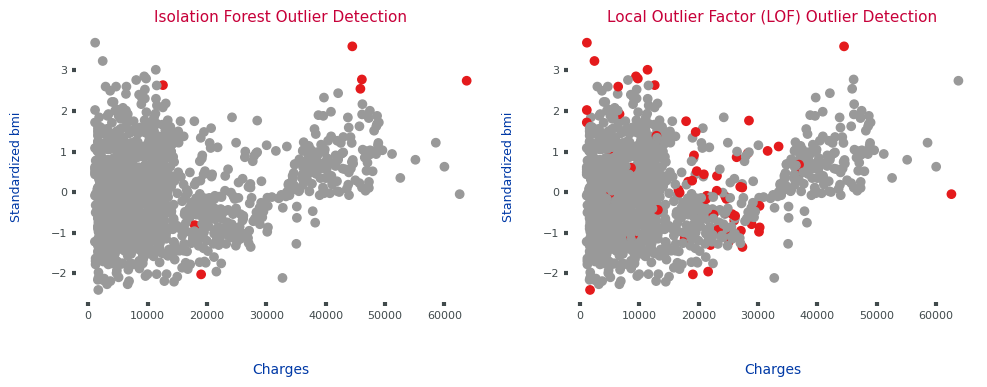

In [132]:
def format_plot(ax, x_label, y_label):
    for spine in ax.spines.values():
        spine.set_linewidth(0)
    ax.set_ylabel(y_label, fontsize=9, labelpad=20, color="#0039A6")
    ax.set_xlabel(x_label, fontsize=10, labelpad=30, color="#0039A6")
    ax.tick_params(axis='x', colors='#414A4C', length=3, width=3, labelsize=8)
    ax.tick_params(axis='y', colors='#414A4C', length=3, width=3, labelsize=8)

# Extract the charges column (target variable)
ds = df.copy()
charges = ds['charges'].values.reshape(-1, 1)

# Encode categorical features
ds = encode_categoricals(ds)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ds)

# Apply Isolation Forest for outlier detection
iso_forest = IsolationForest(contamination=0.005)
iso_preds = iso_forest.fit_predict(X_scaled)

# Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(contamination=0.05)
lof_preds = lof.fit_predict(X_scaled)

# Visualize the results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(charges, X_scaled[:, 2], c=iso_preds, cmap='Set1')
ax=plt.gca()
format_plot(ax, 'Charges', 'Standardized bmi')
plt.title('Isolation Forest Outlier Detection', fontsize=11, color='#C70039')

plt.subplot(1, 2, 2)
plt.scatter(charges, X_scaled[:, 2], c=lof_preds, cmap='Set1')
ax=plt.gca()
format_plot(ax, 'Charges', 'Standardized bmi')
plt.title('Local Outlier Factor (LOF) Outlier Detection', fontsize=11, color='#C70039')

plt.tight_layout()
plt.show()

Display outliers in the dataset :

In [134]:
# Return outlier observations using Isolation Forest
iso_outliers = ds[iso_preds == -1]
print("Outliers detected by Isolation Forest:\n")
printout(iso_outliers, show_index=True)

# Return outlier observations using LOF
lof_outliers = ds[lof_preds == -1]
print("\n\nOutliers detected by Local Outlier Factor:\n")
printout(lof_outliers, show_index=True)

Outliers detected by Isolation Forest:



,age,sex,bmi,children,smoker,charges
438,52,0,46.75,5,1,12592.53
494,21,1,25.7,4,0,17942.11
543,54,0,47.41,0,0,63770.43
549,43,0,46.2,0,0,45863.21
859,37,0,47.6,2,0,46113.51
1046,22,1,52.58,1,0,44501.4
1084,39,0,18.3,5,0,19023.26




Outliers detected by Local Outlier Factor:



,age,sex,bmi,children,smoker,charges
3,33,1,22.7,0,1,21984.47
9,60,0,25.84,0,1,28923.14
32,19,0,28.6,5,1,4687.8
62,64,1,24.7,1,1,30166.62
102,18,0,30.11,0,1,21344.85
115,60,1,28.59,0,1,30260
116,58,1,49.06,0,1,11381.33
140,34,1,22.42,2,1,27375.9
166,20,0,37,5,1,4830.63
172,18,1,15.96,0,1,1694.8


Display the descriptive statistics before and after eliminating outliers

In [136]:
def print_cleaned_data_stats(cleaned_data, outlier_type):
    print(f"\n\nCleaned Data after removing {outlier_type} outliers:\n")
    printout(cleaned_data[nums].describe(), show_index=True)

# Remove outliers detected by Isolation Forest
data_cleaned_iso = ds[iso_preds == 1]

# Remove outliers detected by Local Outlier Factor
data_cleaned_lof = ds[lof_preds == 1]

print("Original Data before removing outliers:\n")
printout(df.describe(), show_index=True)

# Print cleaned data stats
print_cleaned_data_stats(data_cleaned_iso, 'Isolation Forest')
print_cleaned_data_stats(data_cleaned_lof, 'Local Outlier Factor')

Original Data before removing outliers:



,age,bmi,children,charges
count,1337,1337,1337,1337
mean,39.22,30.66,1.1,13279.12
std,14.04,6.1,1.21,12110.36
min,18,15.96,0,1121.87
25%,27,26.29,0,4746.34
50%,39,30.4,1,9386.16
75%,51,34.7,2,16657.72
max,64,53.13,5,63770.43




Cleaned Data after removing Isolation Forest outliers:



,age,bmi,children,charges
count,1330,1330,1330,1330
mean,39.23,30.61,1.09,13161.19
std,14.05,6.01,1.2,11963.11
min,18,15.96,0,1121.87
25%,27,26.3,0,4724.37
50%,39,30.33,1,9303.3
75%,51,34.59,2,16443.29
max,64,53.13,5,62592.87




Cleaned Data after removing Local Outlier Factor outliers:



,age,bmi,children,charges
count,1270,1270,1270,1270
mean,39.3,30.55,1.08,12934.53
std,13.98,5.93,1.16,12067.22
min,18,16.82,0,1121.87
25%,27,26.22,0,4625.25
50%,39.5,30.3,1,9053.38
75%,51,34.5,2,14585.95
max,64,47.6,5,63770.43


***Insights*** : Taking a closer look at the chart and statistical tables above, it looks like ISO performing better than LOF, but both detectors are not performing as well as they should, as they have a high rate of false positives. This indicates that these detectors are incorrectly identifying a significant number of data points as outliers when they are actually not. It is important to consider alternative outlier detection methods that can provide more accurate results in our specific case. Additionally, further analysis and evaluation of the data may be required to understand the underlying factors contributing to these false positives and refine our outlier detection approach accordingly.

*USING : TensorFlow  AutoEncoder*

In [197]:
def standardize_features(data):
    """Standardize the features of the dataframe."""
    ds = data.copy()
    ds = encode_categoricals(ds)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(ds)
    return X_scaled

def build_autoencoder(input_dim,X_scaled):
    """Build and train autoencoder for outlier detection."""
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(input_dim, activation='linear')
    ])
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)
    return autoencoder

def calculate_errors(autoencoder, X_scaled):
    """Calculate reconstruction errors."""
    reconstructions = autoencoder.predict(X_scaled)
    reconstruction_errors = np.mean(np.square(X_scaled - reconstructions), axis=1)
    return reconstruction_errors

def remove_outliers(data, reconstruction_errors):
    """Identify and remove outliers."""
    threshold = np.percentile(reconstruction_errors, 92)
    outlier_indices = np.where(reconstruction_errors > threshold)[0]
    data_cleaned_autoencoder = data.drop(outlier_indices)
    data_cleaned_autoencoder = data_cleaned_autoencoder.reset_index(drop=True)
    return data_cleaned_autoencoder, threshold

def display_data(data, data_cleaned_autoencoder, num_features):
    """Display original and cleaned data."""
    print("Original Data before removing outliers:\n")
    printout(data.describe(), show_index=True)

    print("\n\nCleaned Data after removing Autoencoder outliers:\n")
    printout(data_cleaned_autoencoder[num_features].describe(), show_index=True)

# Using the helper functions
X_scaled = standardize_features(df)
input_dim = X_scaled.shape[1]
autoencoder = build_autoencoder(input_dim,X_scaled)
reconstruction_errors = calculate_errors(autoencoder, X_scaled)
data_cleaned_autoencoder, threshold = remove_outliers(df, reconstruction_errors)
display_data(df, data_cleaned_autoencoder, nums)

42/42 [==============================] - 0s 1ms/step
Original Data before removing outliers:



,age,bmi,children,charges
count,1337,1337,1337,1337
mean,39.22,30.66,1.1,13279.12
std,14.04,6.1,1.21,12110.36
min,18,15.96,0,1121.87
25%,27,26.29,0,4746.34
50%,39,30.4,1,9386.16
75%,51,34.7,2,16657.72
max,64,53.13,5,63770.43




Cleaned Data after removing Autoencoder outliers:



,age,bmi,children,charges
count,1230,1230,1230,1230
mean,39.49,30.81,1.08,12432.59
std,14.01,5.97,1.2,11901.27
min,18,15.96,0,1121.87
25%,27,26.51,0,4464.06
50%,40,30.5,1,8589.57
75%,51,34.8,2,13614.11
max,64,52.58,5,63770.43


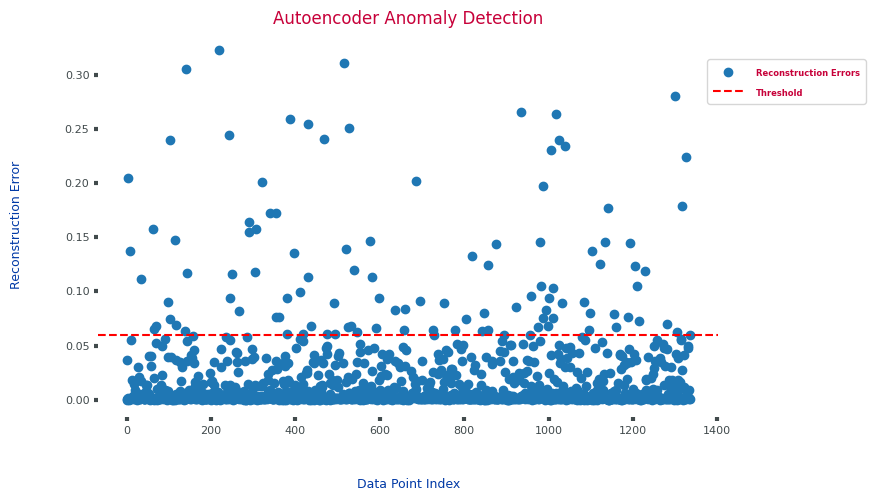

In [198]:
#Plot reconstruction errors
fig, ax = plt.subplots(figsize=(8, 5))
colors = {'axes': '#0039A6', 'title': '#C70039', 'ticks': '#414A4C'}
fontsize = {'labels': 9, 'title': 12, 'legend': 6, 'legend_title': 8}
tick_params = {'length': 3, 'width': 3, 'labelsize': 8}

# Scatter plot
ax.scatter(range(len(reconstruction_errors)), reconstruction_errors, cmap='Set1', marker='o', label='Reconstruction Errors')

# Threshold line
ax.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

# Hide axes spines
for spine in ax.spines.values():
    spine.set_linewidth(0)

# Set labels
ax.set_ylabel('Reconstruction Error', fontsize=fontsize['labels'], labelpad=30, color=colors['axes'])
ax.set_xlabel('Data Point Index', fontsize=fontsize['labels'], labelpad=30, color=colors['axes'])

# Set ticks
ax.tick_params(axis='x', colors=colors['ticks'], **tick_params)
ax.tick_params(axis='y', colors=colors['ticks'], **tick_params)

# Set title
ax.set_title('Autoencoder Anomaly Detection', fontsize=fontsize['title'], color=colors['title'])

# Set legend
legend = ax.legend(loc='upper right', bbox_to_anchor=(1.25, 0.95))
plt.setp(legend.get_texts(), fontsize=fontsize['legend'], fontweight='bold', color=colors['title'])
plt.setp(legend.get_title(), fontsize=fontsize['legend_title'], color=colors['title'])

plt.show()

**Normalize and Split Data**

In [166]:
# normalize and split
def split_data(data, use_log=False):
    target_var = 'charges'
    numerical_vars = ['age', 'bmi', 'children']
    test_size = 0.2
    random_state_val = 42

    X, y = prepare_data_variables(data, target_var, use_log)
    X, scaler = preprocess_features(X, numerical_vars)

    return split_dataset(X, y, test_size, random_state_val, scaler)

def prepare_data_variables(data, target_var, use_log):
    X = data.drop(target_var, axis=1)
    y = np.log10(data[target_var]) if use_log else data[target_var]
    return X, y

def preprocess_features(X, numerical_vars):
    X_num, X_cat = split_numerical_categorical(X, numerical_vars)
    X_num, scaler = scale_numerical_features(X_num)
    X_cat = encode_categorical_features(X_cat)
    return pd.concat([X_num, X_cat], axis=1), scaler

def split_numerical_categorical(data, numerical_vars):
    return data[numerical_vars], data.drop(numerical_vars, axis=1)

def scale_numerical_features(data_num):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns), scaler

def encode_categorical_features(data_cat):
    encoder = OneHotEncoder(drop='first', sparse=False)
    data_cat_encoded = encoder.fit_transform(data_cat)
    return pd.DataFrame(data_cat_encoded, columns=encoder.get_feature_names_out(data_cat.columns))

def split_dataset(X, y, test_size, random_state, scaler):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return scaler, X, y, X_train, X_test, y_train, y_test

In [199]:
scaler, X, y, X_train, X_test, y_train, y_test = split_data(data_cleaned_autoencoder)
print(X_train.shape, y_train.shape,
      X_test.shape, y_test.shape)


(984, 5) (984,) (246, 5) (246,)


## **[ 8 ] Models**

In [200]:
#OLS Regression
x2 = sm.add_constant(np.asarray(X_train))
#fit linear regression model
model = sm.OLS(y_train, x2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     1246.
Date:                Mon, 04 Sep 2023   Prob (F-statistic):               0.00
Time:                        16:43:31   Log-Likelihood:                -9652.2
No. Observations:                 984   AIC:                         1.932e+04
Df Residuals:                     978   BIC:                         1.935e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7496.4314    208.696     35.920      0.000    7086.889    7905.974
x1          3593.0878    140.652     25.546      0.000    3317.073    3869.103
x2          1770.3597    140.415     12.608      0.000    1494.810    2045.910
x3           549.4349    140.664      3.906      0.000     273.396     825.474
x4           -76.3320    282.732     -0.270      0.787    -631.163     478.499
x5          2.571e+04    357.705     71.886      0.000     2.5e+04    2.64e+04
==============================================================================
Omnibus:                       51.257   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.560
Skew:                          -0.116   Prob(JB):                     6.79e-37
Kurtosis:                       5.002   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

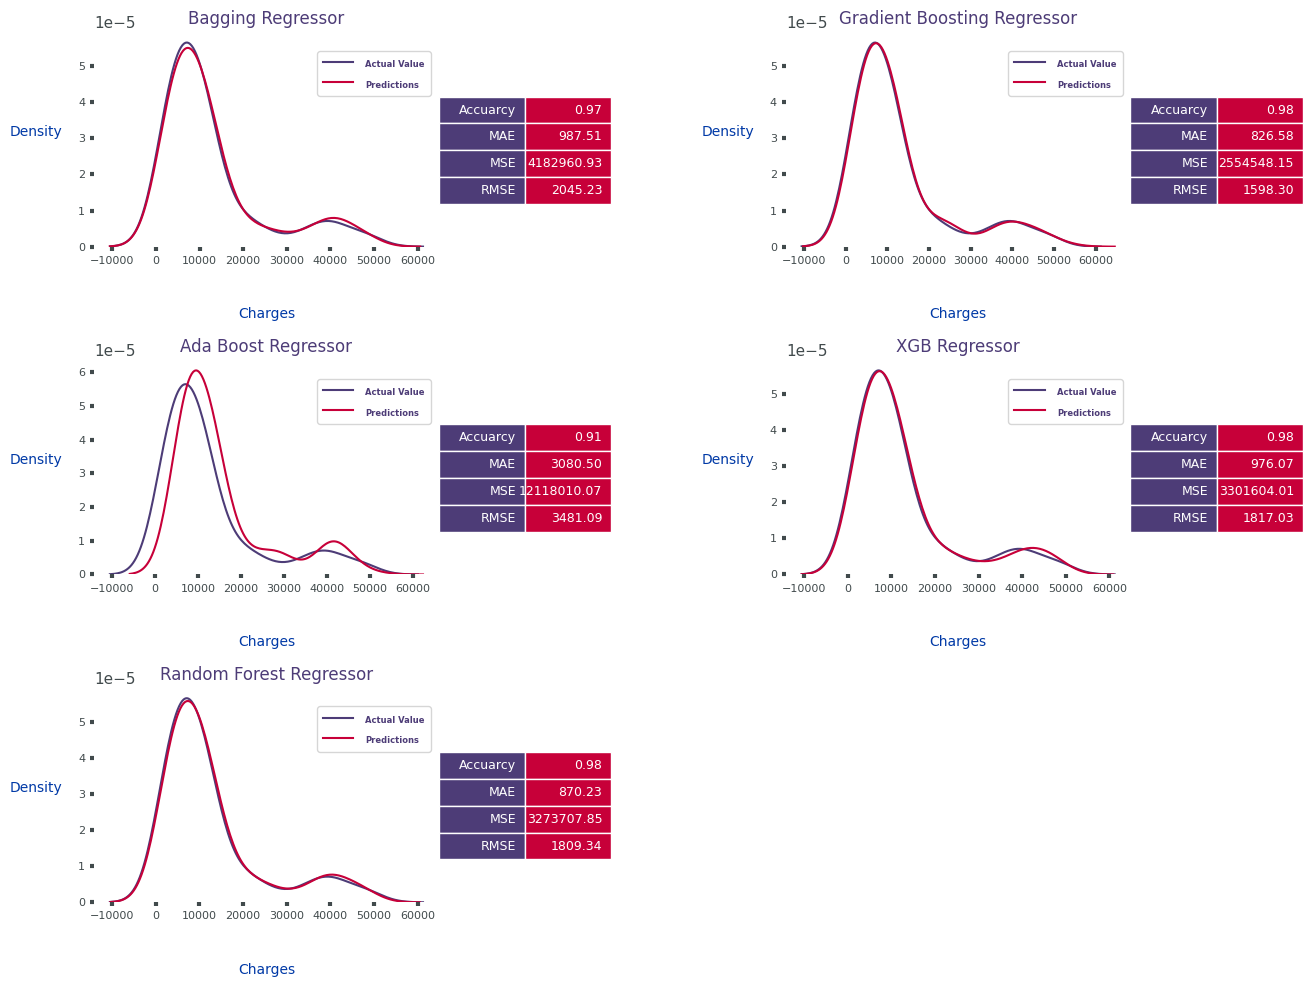

In [218]:
#Define a function for model training and prediction
def train_and_predict(models, X_train, y_train, X_test, y_test):
    results, preds = [], []
    for model_name, model in models:
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        predictions = model.predict(X_test)
        preds.append([model_name, model, "{:.2f}".format(accuracy), predictions])
        results.append([model_name, "{:.2f}".format(accuracy)])
    results.sort(key=lambda x: x[1], reverse=True)
    return results, preds

# Define models
models = [
    ("Bagging Regressor", BaggingRegressor(tree.DecisionTreeRegressor(random_state=1))),
    ("Gradient Boosting Regressor", GradientBoostingRegressor()),
    ("Ada Boost Regressor", AdaBoostRegressor()),
    ("XGB Regressor", xgb.XGBRegressor()),
    ("Random Forest Regressor", RandomForestRegressor(n_estimators=100, criterion='squared_error', min_samples_split=2))
    # Add more models here
]

# Train models and make predictions
results, preds = train_and_predict(models, X_train, y_train, X_test, y_test)

# Display results in a table
table_headers = ["Model", "Accuracy"]
table = tabulate(results, headers=table_headers, tablefmt="pretty")
#print(table)

# Plotting
num_plots = len(models)
num_rows = int(np.ceil(np.sqrt(num_plots)))
num_cols = int(np.ceil(num_plots / num_rows))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, 10))

for i, (model_name, model, accuracy, predictions) in enumerate(preds):
    ax = axes[i // num_cols, i % num_cols]
    sns.distplot(y_test, hist=False, color="#4D3C77", label="Actual Value", ax=ax)
    sns.distplot(predictions, hist=False, color="#C70039", label="Predictions" , ax=ax)
    metrics_data = [['Accuarcy', accuracy],
                    ['MAE', "{:.2f}".format(metrics.mean_absolute_error(y_test, predictions))],
                    ['MSE', "{:.2f}".format(metrics.mean_squared_error(y_test, predictions))],
                    ['RMSE', "{:.2f}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions)))]]
    table = ax.table(cellText=metrics_data, edges='closed', bbox=[1,0.2,0.5,0.5],
                     cellColours=[["#4D3C77", "#C70039"]]*4)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    for cell in table.get_celld().values():
        cell.get_text().set_color('white')
        cell.set_edgecolor('white')
    ax.set_title(f"{model_name}", fontsize=12, color = "#4D3C77")
    for spine in ax.spines.values():
        spine.set_linewidth(0)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Setting the labels for the axis
    ax.set_ylabel("Density", fontsize=10, rotation=360, labelpad=30, color="#0039A6")
    ax.set_xlabel("Charges", fontsize=10, rotation=360, labelpad=30, color="#0039A6")
    tick_params={'colors':'#414A4C', 'length':3, 'width':3, 'labelsize':8}
    # Setting the tick parameters
    ax.tick_params(axis='x', **tick_params)
    ax.tick_params(axis='y', **tick_params)
    legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 0.95))
    plt.setp(legend.get_texts(), fontsize=fontsize['legend'], fontweight='bold', color="#4D3C77")

# Remove empty subplots
for i in range(len(models), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig('models.png')
plt.show()

In [155]:
# save the iris classification model as a pickle file
#model_pkl_file = "gbr__for_mhip_98.pkl"

#with open(model_pkl_file, 'wb') as file:
#    pickle.dump(model, file)

In [156]:
#joblib.dump(scaler, 'scaler.pkl')

**Pass new data**

In [172]:
def load_model(model_path: str, scaler_path: str):
    """
    Load the saved model and scaler.
    """
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    return model, scaler

def create_dataframe(values: List[Union[int, float]], column_names: List[str]) -> pd.DataFrame:
    """
    Create a pandas DataFrame from the provided values and column names.
    """
    data = dict(zip(column_names, values))
    df = pd.DataFrame([data])

    return df

def scale_and_format_data(df: pd.DataFrame, scaler) -> pd.DataFrame:
    """
    Scale and format the data in the DataFrame.
    """
    # Scale the numerical columns
    df.iloc[:,:3] = scaler.transform(df.iloc[:,:3])

    # Apply formatting function to all values in the DataFrame
    format_function = lambda x: f'{x:.2f}'
    df = df.applymap(format_function)

    return df

def predict_charges(model, data: pd.DataFrame) -> float:
    """
    Make predictions on the data.
    """
    charges = model.predict(df.values)

    return "{:.2f} $".format(charges[0])

# Define constants
MODEL_PATH = '/content/gdrive/MyDrive/Colab_Notebooks/Medical Health Insurance Cost Prediction /rfr__for_mhip_98.pkl'
SCALER_PATH = '/content/gdrive/MyDrive/Colab_Notebooks/Medical Health Insurance Cost Prediction /scaler.pkl'
VALUES = [20, 30.5 , 2 , 0 , 0]
COLUMN_NAMES = ['age', 'bmi', 'children', 'sex', 'smoker']

# Load the model and scaler
model, scaler = load_model(MODEL_PATH, SCALER_PATH)

# Create a DataFrame
new_df = create_dataframe(VALUES, COLUMN_NAMES)

# Scale and format the data
new_df = scale_and_format_data(new_df, scaler)

# Make predictions
charges = predict_charges(model, new_df)

print(charges)

2164.86 $


⚓ ⚓ ⚓  **END**  ⚓ ⚓ ⚓


### **Key Insights**
1. According to our analysis of the dataset, the most influential factors influencing medical insurance charges are whether the person is a smoker, their BMI (body mass index), and their age.

2. Compared to non-smokers, smokers frequently face significantly higher medical insurance premiums. This important realization emphasizes how lifestyle decisions have a significant impact on healthcare expenditures.

3. An individual's age and the cost of their insurance are strongly associated. Given the higher risk of health problems as people age, it makes sense that older people tend to have higher medical costs.

4. Higher BMI values are associated with higher medical insurance premiums. This implies that keeping a healthy weight can reduce healthcare costs.

5. We evaluated multiple regression models, including Random Forest Regressor, Gardient Boosting Regressor, Bagging Regressor, AdaBoost Regressor, and XGBRegressor. Among these, the Gardient Boosting Regressor and Random Forest Regressor showed better performance in predicting medical insurance charges.

6. Gradient Boosting Regression model showed the lowest Mean Absolute Error, Mean Square Error, and Root Mean Square Error among all models, indicating its capability to better capture the underlying patterns in the data.



## **Conclusion**
This project highlights the process of estimating medical health insurance charges using numerous regression models. Regression models are statistical tools that analyze the relationship between dependent and independent variables. By utilizing these models, this project aims to provide insights into the factors that influence medical health insurance costs and develop accurate predictions based on the available data. Additionally, it explores the effectiveness of different regression techniques such as linear regression, bagging regression, gradient boosting regression, and random forest regression in capturing the complexity of this domain. In order to provide precise forecasts in the field of estimating medical insurance costs, the project emphasizes the significance of data preparation, model selection, and evaluation.